<a href="https://colab.research.google.com/github/svetazo060510/goit-numpr-hw-02/blob/main/HW2_StremedlovskaS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання Тема 2

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import os
from PIL import Image

In [7]:
# 1. Список зображень
# Файли завантажені в корінь Colab
image_files = ['StarbucksLogo.png', 'Cat.png', 'Landscape.jpg']
k_values = [10, 50, 150]  # Значення k для порівняння якості

Зображення StarbucksLogo.png зменшено до (790, 800)


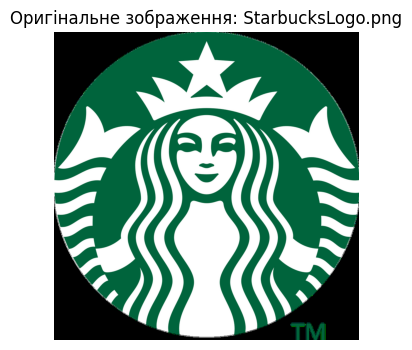

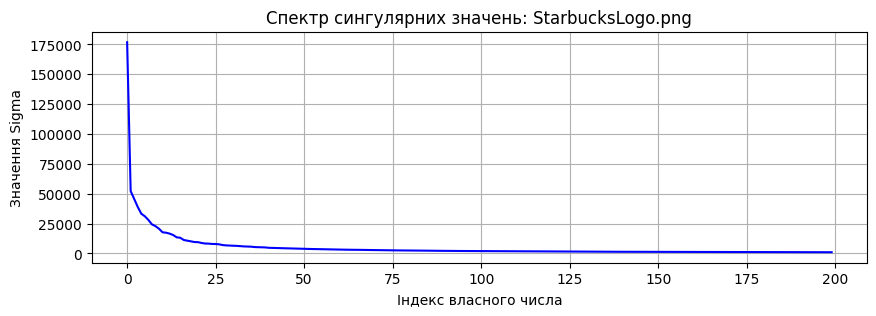

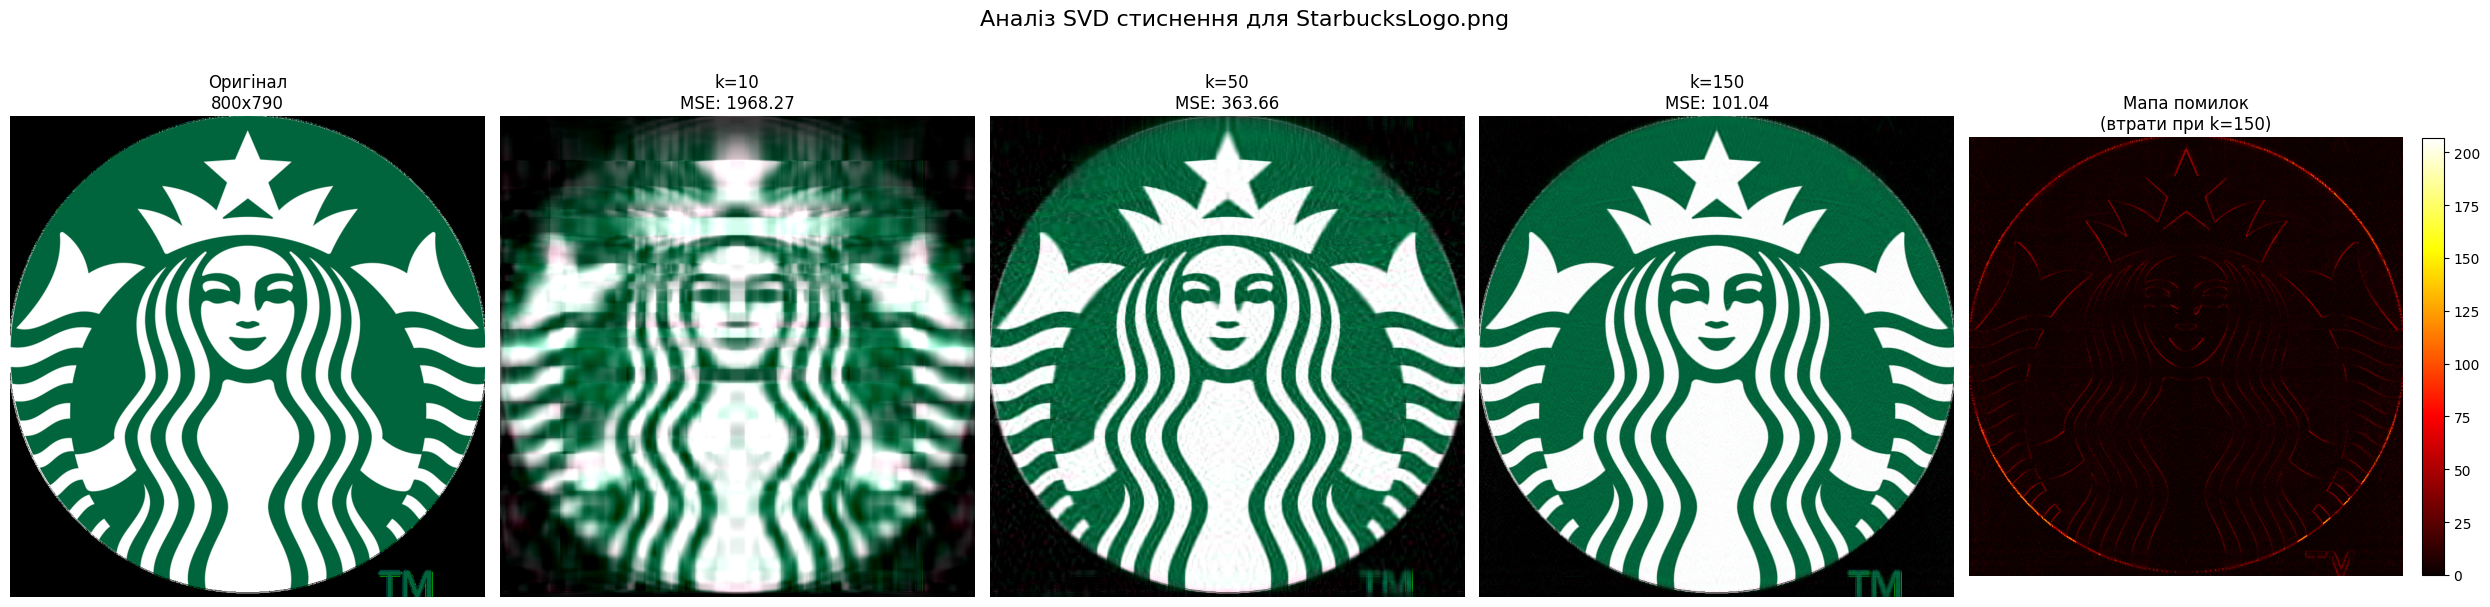

Зображення Cat.png зменшено до (800, 533)


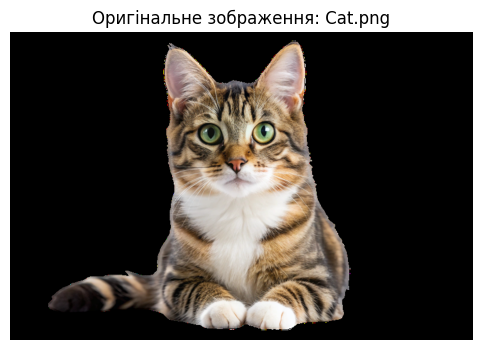

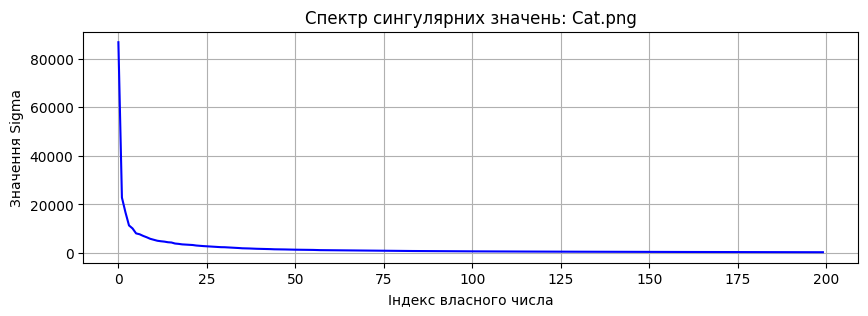

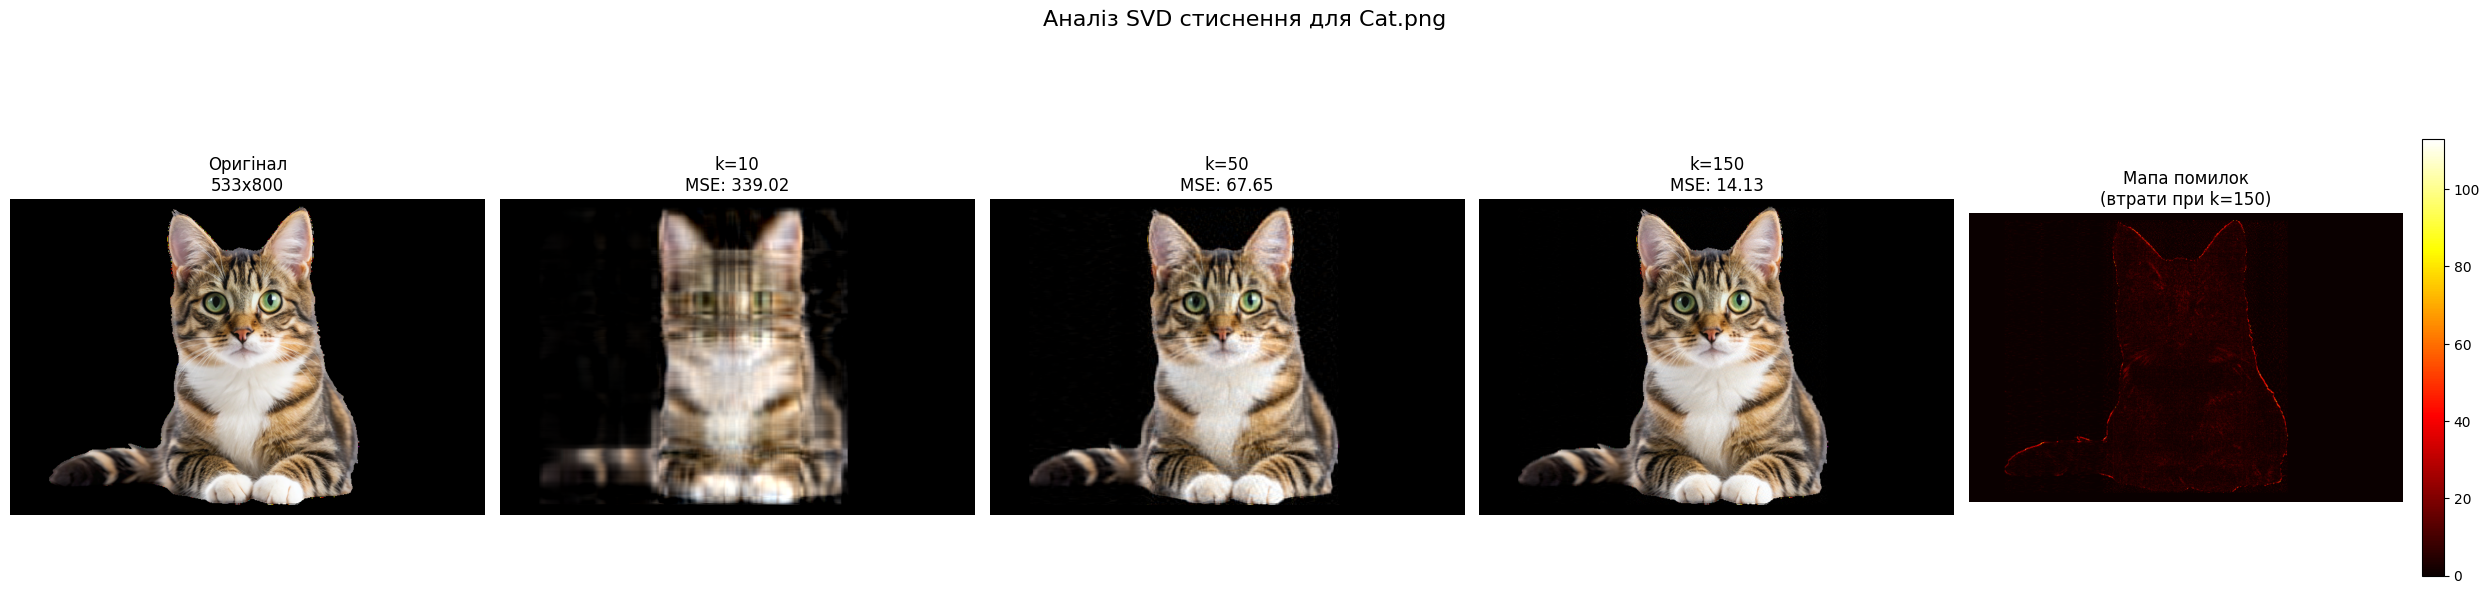

Зображення Landscape.jpg зменшено до (800, 533)


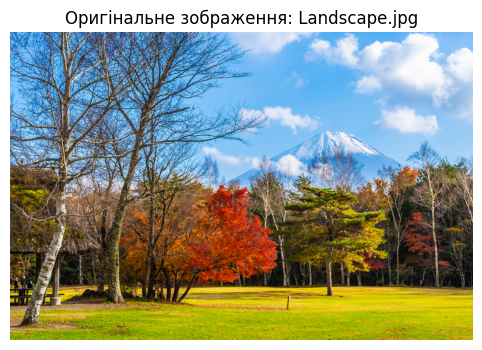

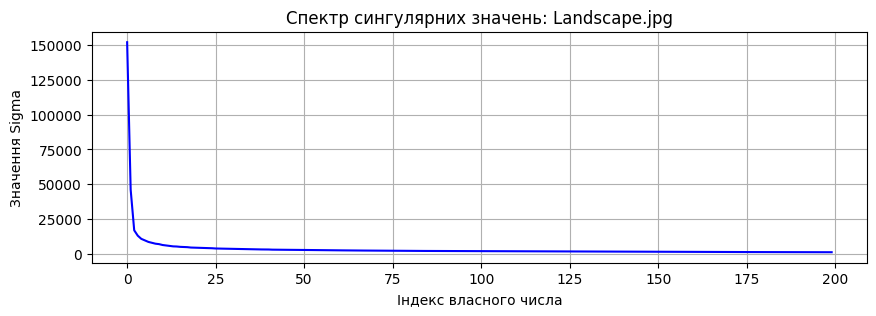

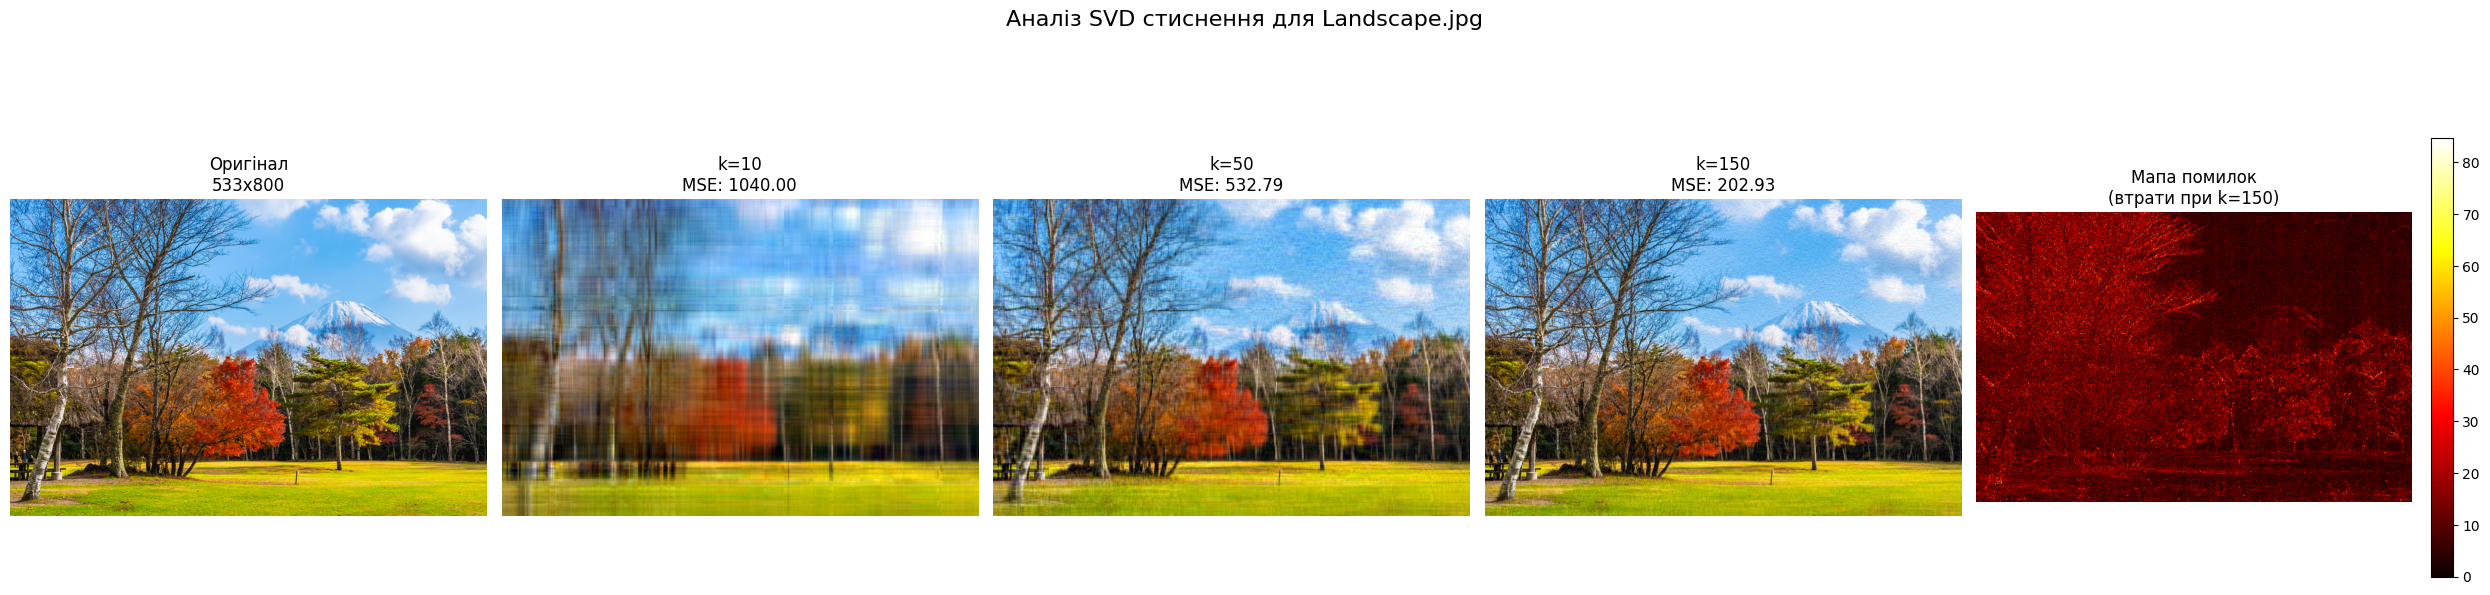

In [10]:
for file_name in image_files:
    if not os.path.exists(file_name):
        continue

    # 2. Завантаження через PIL для попередньої обробки
    with Image.open(file_name) as img:
        # Ресайз: якщо фото велике, зменшуємо його до макс. 800 пікселів по більшій стороні
        max_size = 800
        if max(img.size) > max_size:
            ratio = max_size / max(img.size)
            new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
            img = img.resize(new_size, Image.Resampling.LANCZOS)
            print(f"Зображення {file_name} зменшено до {new_size}")

        # Конвертуємо в RGB (видаляємо прозорість, якщо вона є)
        img = img.convert('RGB')
        image = np.array(img)

    # Вивід оригінального фото
    plt.figure(figsize=(6, 4))
    plt.imshow(image)
    plt.title(f"Оригінальне зображення: {file_name}")
    plt.axis('off')
    plt.show()

    # 3. Визначення розмірів (оптимізовані)
    height, width, channels = image.shape

    # 4. Решейп у 2D (укладання каналів горизонтально)
    flat_image = image.reshape(-1, width * channels)

    # 5. Повний SVD для візуалізації сингулярних значень
    _, S, _ = np.linalg.svd(flat_image, full_matrices=False)

    # 6. Візуалізація графіка Sigma
    plt.figure(figsize=(10, 3))
    plt.plot(S[:200], color='blue')
    plt.title(f"Спектр сингулярних значень: {file_name}")
    plt.xlabel("Індекс власного числа")
    plt.ylabel("Значення Sigma")
    plt.grid(True)
    plt.show()

    # 7-10. Експерименти з k та побудова мапи помилок
    # Створюємо сітку: Оригінал | k=10 | k=50 | k=150 | Мапа помилок (для останнього k)
    num_plots = len(k_values) + 2
    fig, axes = plt.subplots(1, num_plots, figsize=(25, 6))

    # Вивід оригіналу
    axes[0].imshow(image)
    axes[0].set_title(f"Оригінал\n{height}x{width}")
    axes[0].axis('off')

    last_reconstructed = None

    for i, k in enumerate(k_values):
        # Truncated SVD декомпозиція
        svd = TruncatedSVD(n_components=k)
        truncated_data = svd.fit_transform(flat_image)

        # 8. Реконструкція
        reconstructed_flat = svd.inverse_transform(truncated_data)

        # Розрахунок MSE (помилка)
        mse = np.mean(np.square(reconstructed_flat - flat_image))

        # Розрахунок Compression Ratio (Коефіцієнт стиснення)
        original_elements = flat_image.size
        compressed_elements = k * (height + (width * channels) + 1)
        compression_ratio = original_elements / compressed_elements

        # 9. Повернення 3D форми та кліпінг
        reconstructed_image = reconstructed_flat.reshape(height, width, channels)
        reconstructed_image = np.clip(reconstructed_image, 0, 255).astype('uint8')
        last_reconstructed = reconstructed_image

        axes[i+1].imshow(reconstructed_image)
        axes[i+1].set_title(f"k={k}\nMSE: {mse:.2f}")
        axes[i+1].axis('off')

    # Побудова Мапи Помилок (Error Map) для останнього значення k
    # Показуємо різницю між оригіналом та останньою копією
    error_map = np.abs(image.astype(float) - last_reconstructed.astype(float))
    # Усереднюємо по каналах для чіткості
    error_viz = error_map.mean(axis=2)

    img_err = axes[-1].imshow(error_viz, cmap='hot')
    axes[-1].set_title(f"Мапа помилок\n(втрати при k={k_values[-1]})")
    axes[-1].axis('off')
    plt.colorbar(img_err, ax=axes[-1], fraction=0.046, pad=0.04)

    plt.suptitle(f"Аналіз SVD стиснення для {file_name}", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()
    print("="*120)

## Висновки

Результати експерименту демонструють, що ефективність стиснення критично залежить від матричного рангу та складності візуальної структури:
1. StarbucksLogo.png (Проста структура):
* Аналіз: Матриця логотипу має високий ступінь лінійної залежності рядків через великі однотонні області.
* Результат: Навіть при низькому $k=10$ зображення залишається впізнаваним, а при $k=50$ воно візуально не відрізняється від оригіналу.
* Висновок: Для графічних символів та логотипів SVD забезпечує екстремально високий коефіцієнт стиснення (Ratio) при мінімальному MSE.
2. Cat.jpg (Текстурований об'єкт):
* Аналіз: Шерсть кота та вуса представляють собою високочастотну інформацію.
* Результат: При низьких $k$ мапа помилок (Error Map) яскраво підсвічує контури морди та текстуру шерсті. Це означає, що ці деталі "губляться" першими.
* Висновок: Тварини та деталізовані об'єкти потребують більшого значення $k$ для збереження реалістичності.
3. Landscape.jpg (Складний природний об'єкт):
* Аналіз: Велика кількість дрібних деталей (листя, трава) та плавні колірні градієнти неба.
* Результат: Навіть при $k=150$ мапа помилок показує значні втрати в зонах з дрібною рослинністю.
* Висновок: Природні пейзажі мають найвищий ранг матриці, тому стиснення через SVD для них є менш ефективним порівняно з рукотворними об'єктами.